
# Create SiPM PSF for NEXT-100 (using detsim), to use with Beersheba. 

In [1]:
import os
import glob
import numpy  as np
import pandas as pd
import tables as tb
import h5py

from IC.invisible_cities.reco.psf_functions    import create_psf
from IC.invisible_cities.reco.psf_functions    import hdst_psf_processing
from IC.invisible_cities.reco.psf_functions    import add_empty_sensors_and_normalize_q
from IC.invisible_cities.reco.psf_functions    import add_variable_weighted_mean

import IC.invisible_cities.core.core_functions as     coref
import IC.invisible_cities.io.dst_io         as     dstio

from IC.invisible_cities.database              import load_db
from IC.invisible_cities.io.kdst_io      import psf_writer

Note: I had to change the path for the database files in invisible cities, because it was calling an error. 

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]          = 10, 10
plt.rcParams["font.size"]               = 16
plt.rcParams["figure.max_open_warning"] = 100

In [3]:
db = load_db.DataSiPM('next100', -1)

In [4]:
# Input and output path
psf_path   = '/Users/halmamol/NEXT/files/NEXT100/psf/'
psf_filename = 'next100.kr83m.psf.h5'
out_psf  = psf_path + psf_filename

psf_files = glob.glob(psf_path+'psf_*.h5')

*Below*: When I call the files, it sais that the first one is the 24 but there is a file 1.


In [5]:
psf_files[0]

'/Users/halmamol/NEXT/files/NEXT100/psf/psf_24.h5'

### 1-Check if penthesilea (kr_penthesilea) files are correct

Opening file, to retrieve important variables storaged in RECO/Events (X and Y rms, charge, energy, trackID):

In [6]:
myfile = ['/Users/halmamol/NEXT/files/NEXT100/psf/kr_penthesilea/next100.kr83m.45.psf_hits.h5']
df = dstio.load_dsts(myfile, 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], 
                                                    axis='columns').reset_index(drop=True)

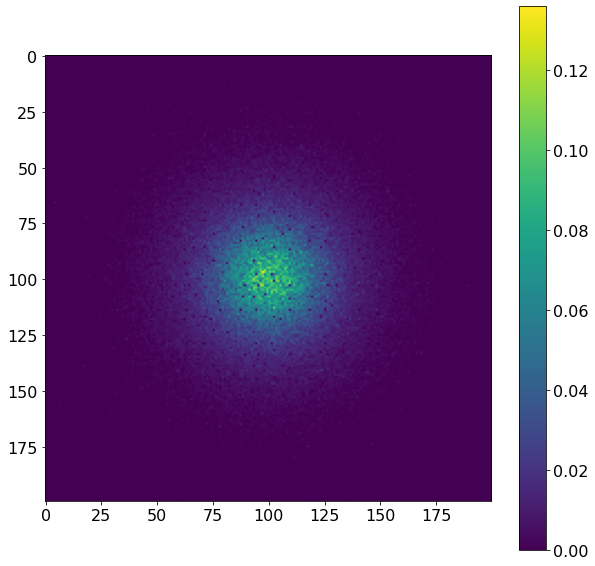

In [7]:
### Use all z to have more statistics
plt.rcParams["figure.figsize"]  = 10, 10

bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

# "hdst_psf_processing" fucntion: adds necessary info to a hits DST to create the PSF, 
# namely the relative position and the normalized Q.

hdstA = hdst_psf_processing(df, [Xrange, Yrange], db)
hdst = hdstA[coref.in_range(hdstA.Z, 0, 2000)]
bin_edges = [np.linspace(*rr, [nbinX, nbinY][i]+1) for i, rr in enumerate([Xrange, Yrange])]

# "create_psf" function takes:
# - the hits relative position in 2D (hdst.RelX.values, hdst.RelY.values), 
# - the hits SiPM charge normalized to the total peak charge (hdst.NormQ)
# - bin edges for the PSF in each dimension (bin_edges)

# and it retrieves:
# - the point-spread function, 
# - number of entries per bin in the PSF, 
# - bin centers of the PSF.

psf_new, entries_new, bins_new = create_psf((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, 
                                             bin_edges)
plt.imshow(psf_new)
plt.colorbar()

### 2-Code to create PSF 

In [8]:
## Defining "compute_psf" function:
## - It creates a test file ("prova")
## - It uses one big bin in xy.
## - In the writer function, 0., 0. are the xy average of the particular xy bin.
## - Other two loops should be added if more bins were to be used.

def compute_psf(df, fnumber):
    out_psf = psf_path + 'psf_prova_{}.h5'.format(fnumber)
#    print(out_psf)

    with tb.open_file(out_psf, 'w') as outfile:
        # Declare the PSF writer
        writer = psf_writer(outfile)

        for z in zrange:
            z_sel = coref.in_range(df.Z, z, z+z_step) 
            # Preprocess the data before extracting the PSF (same as before)
            hdst = hdst_psf_processing(df[z_sel], [Xrange, Yrange], the_db)
            # Safety check (single sipm events not considered to be physical)
            hdst = hdst[hdst.nsipm > 1]

            # Loop to extract the PSF in different regions.
            bin_edges = [np.linspace(*rr, [nbinX, nbinY][i]+1) for i, rr in enumerate([Xrange, Yrange])]
            psf_new, entries_new, bins_new = create_psf((hdst.RelX.values, hdst.RelY.values), hdst.NormQ, 
                                                         bin_edges)

            writer(bins_new[0], bins_new[1], [0], 0., 0., z + z_step/2, 
                           np.asarray([psf_new]).transpose((1, 2, 0)), np.asarray([entries_new]).transpose((1, 2, 0)))

In [9]:
# Calling the SiPM data from the db
run = -1
the_db = load_db.DataSiPM('next100', run)

z_max  = 1205
z_step = 1205
zrange = []
zrange.extend(np.arange(0, z_max, z_step))

In [10]:
## Checking db is working
the_db

,SensorID,ChannelID,Active,X,Y,adc_to_pes,Sigma
0,1000,1000,1,-489.77,-303.17,17.25,1.677
1,1001,1001,1,-489.77,-287.62,17.25,1.677
2,1002,1002,1,-489.77,-272.07,17.25,1.677
3,1003,1003,1,-489.77,-256.52,17.25,1.677
4,1004,1004,1,-489.77,-240.97,17.25,1.677
...,...,...,...,...,...,...,...
3579,56059,56059,1,489.88,241.08,17.25,1.677
3580,56060,56060,1,489.88,256.63,17.25,1.677
3581,56061,56061,1,489.88,272.18,17.25,1.677
3582,56062,56062,1,489.88,287.73,17.25,1.677


In [11]:
### Definign PSF binning and range (as before)
bin_size   = 1
Xrange     = [ -100, 100]
Yrange     = [ -100, 100]
ranges     = [Xrange, Yrange]
nbinX      = int(np.diff(Xrange)/bin_size)
nbinY      = int(np.diff(Yrange)/bin_size)

#Taking the variables from the files
i = 1
thefile = myfile[0].format(i)
df = dstio.load_dsts([thefile], 'RECO', 'Events').drop(['Xrms', 'Yrms', 'Qc', 'Ec', 'track_id'], axis='columns').reset_index(drop=True)
compute_psf(df, i)

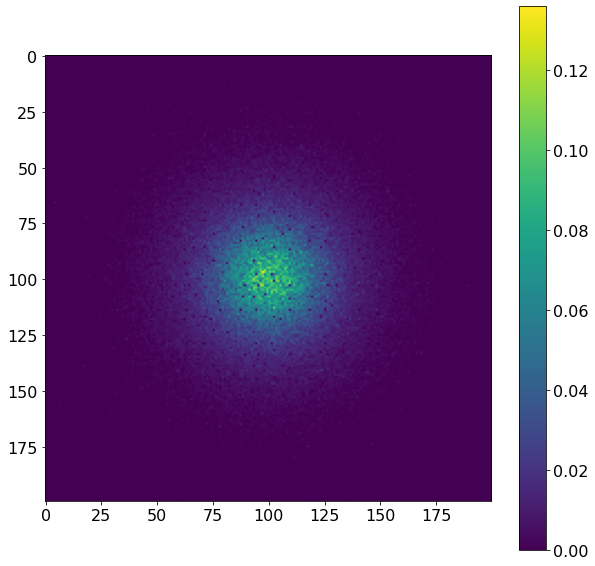

In [12]:
## Test - Crosscheck
plt.imshow(psf_new)
plt.colorbar()

### 3 - Read back the psf (prova) file

In [13]:
provapath = psf_path + 'psf_prova_1.h5'
h5file = tb.open_file(psf_path + 'psf_prova_1.h5')
h5file

File(filename=/Users/halmamol/NEXT/files/NEXT100/psf/psf_prova_1.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/PSF (Group) ''
/PSF/PSFs (Table(40000,), shuffle, zlib(4)) 'XYZ dependent point spread functions'
  description := {
  "nevt": UInt32Col(shape=(), dflt=0, pos=0),
  "xr": Float32Col(shape=(), dflt=0.0, pos=1),
  "yr": Float32Col(shape=(), dflt=0.0, pos=2),
  "zr": Float32Col(shape=(), dflt=0.0, pos=3),
  "x": Float32Col(shape=(), dflt=0.0, pos=4),
  "y": Float32Col(shape=(), dflt=0.0, pos=5),
  "z": Float32Col(shape=(), dflt=0.0, pos=6),
  "factor": Float32Col(shape=(), dflt=0.0, pos=7)}
  byteorder := 'little'
  chunkshape := (2048,)

In [14]:
## Take one of the prova files - NOTE: I had to add 'PSF/PSFs'
psf = pd.read_hdf(psf_path + 'psf_prova_1.h5', 'PSF/PSFs')
print(psf.head())

   nevt    xr    yr   zr    x    y      z  factor
0     1 -99.5 -99.5  0.0  0.0  0.0  602.5     0.0
1     5 -99.5 -98.5  0.0  0.0  0.0  602.5     0.0
2     1 -99.5 -97.5  0.0  0.0  0.0  602.5     0.0
3     3 -99.5 -96.5  0.0  0.0  0.0  602.5     0.0
4     6 -99.5 -95.5  0.0  0.0  0.0  602.5     0.0


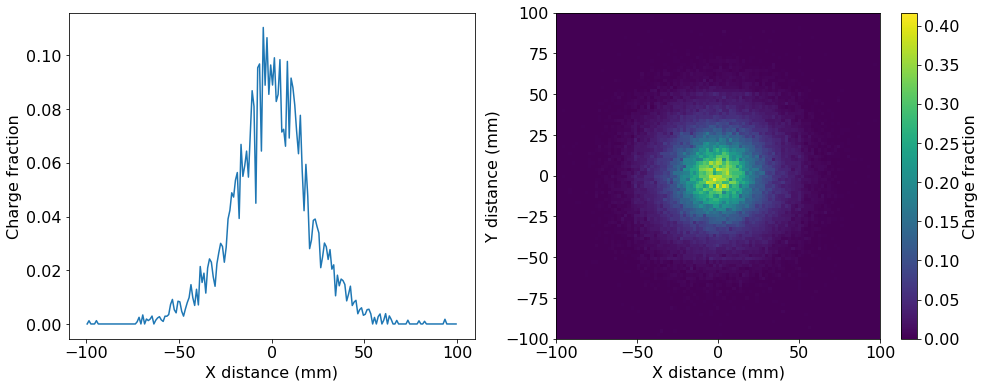

In [15]:
#Checking the psf form
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### 1s - Plot PSF at center (X dimension)
## Taking a specific z and yr value
p1 = psf[(psf.z==602.5) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==602.5)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(Xrange[0], Xrange[1], Xrange[1]), np.linspace(Yrange[0], Yrange[1], Yrange[1])
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')

# Join all PSFs

Now, once all psf files have been created, let's join them to use one file.

In [16]:
# Input and output path

psf_filename = 'next100.kr83m.psf.h5'
out_psf  = psf_path + psf_filename

psf_files = glob.glob(psf_path + 'psf_*.h5')
psf_files

['/Users/halmamol/NEXT/files/NEXT100/psf/psf_24.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_75.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_86.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_41.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_359.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_219.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_188.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_308.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_248.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_775.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_876.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_635.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_724.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_827.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_664.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_446.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_697.h5',
 '/Users/halmamol/NEXT/files/NEXT100/psf/psf_506.h5',
 '/Users/halmamol/NEXT/files/NEX

In [17]:
len(psf_files)

865

It seems some of the files are missing, maybe when moving the files into local

In [18]:
df_psf = pd.read_hdf(psf_files[0], 'PSF/PSFs')
df_psf

,nevt,xr,yr,zr,x,y,z,factor
0,0,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,0,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,0,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,0,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,0,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...
2439995,0,99.5,95.5,0.0,0.0,0.0,1210.0,0.0
2439996,0,99.5,96.5,0.0,0.0,0.0,1210.0,0.0
2439997,0,99.5,97.5,0.0,0.0,0.0,1210.0,0.0
2439998,0,99.5,98.5,0.0,0.0,0.0,1210.0,0.0


In [50]:
evts    = []
factors = []

for i in range(1, 300):
    filein = psf_path + f'psf_{i}.h5'
    try:
        df = pd.read_hdf(filein, 'PSF/PSFs')
    except:
        print(f'{filein} not found')
        continue
        
    if len(df.nevt.values) != 2440000:
        print(i, len(df.nevt.values))
    evts   .append(df.nevt  .values)
    factors.append(df.factor.values)

#for i, filein in enumerate(psf_files):
#    if i % 10 == 0:
#        print(f'{i} files read, current file: {filein}')
#    df = pd.read_hdf(filein)
#    evts   .append(df.nevt  .values)
#    factors.append(df.factor.values)

4 0
/Users/halmamol/NEXT/files/NEXT100/psf/psf_5.h5 not found
6 0
/Users/halmamol/NEXT/files/NEXT100/psf/psf_7.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_8.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_9.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_10.h5 not found
13 0
/Users/halmamol/NEXT/files/NEXT100/psf/psf_14.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_15.h5 not found
16 0
/Users/halmamol/NEXT/files/NEXT100/psf/psf_17.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_18.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_19.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_20.h5 not found
211 2400000
/Users/halmamol/NEXT/files/NEXT100/psf/psf_212.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_213.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_214.h5 not found
/Users/halmamol/NEXT/files/NEXT100/psf/psf_215.h5 not found
276 0
/Users/halmamol/NEXT/files/NEXT100/psf/psf_277.h5 not found
/Users/halmamol/NEX

In [51]:
#It seems I didn't get the last 100 files, and some of them present some error:
len(evts), len(factors)

(272, 272)

In [52]:
df_psf.head()

,nevt,xr,yr,zr,x,y,z,factor
0,7,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,2,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,6,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,2,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,4,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0


In [53]:
df_psf.dtypes

nevt        int32
xr        float32
yr        float32
zr        float32
x         float32
y         float32
z         float32
factor    float64
dtype: object

In [54]:
evts_all    = np.array(evts)
factors_all = np.array(factors)

In [55]:
evts_all

array([array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 2, ..., 0, 0, 0], dtype=uint32),
       array([1, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([], dtype=uint32), array([], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([], dtype=uint32), array([], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
       array([0, 0, 0, ..., 0, 0, 0], 

In [56]:
t_evts_all,t_factors_all  = [], []
for i in range(len(evts_all)):
    if len(evts_all[i]) != 2440000:
        print(i, len(evts_all[i]))
    else: 
        t_evts_all.append(evts_all[i])
        t_factors_all.append(factors_all[i])
        

3 0
4 0
7 0
8 0
199 2400000
260 0
262 0
268 0
271 0


In [57]:
n_t_evts_all = np.array(t_evts_all)
n_t_factors_all = np.array(t_factors_all)

In [58]:
n_t_evts_all

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [59]:
new_evts = n_t_evts_all.sum(axis=0).astype('int32')

In [60]:
new_evts

array([15, 10, 11, ...,  9,  4,  7], dtype=int32)

In [61]:
n_t_factors_all

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [62]:
tmp_factors = (n_t_evts_all * n_t_factors_all).sum(axis=0)

In [63]:
new_factors = tmp_factors / new_evts

<ipython-input-63-9af92a1d9339>:1: RuntimeWarning: invalid value encountered in true_divide
  new_factors = tmp_factors / new_evts


In [64]:
new_factors

array([0., 0., 0., ..., 0., 0., 0.])

In [65]:
df_psf.nevt   = new_evts
df_psf.factor = new_factors

In [66]:
df_psf.head()

,nevt,xr,yr,zr,x,y,z,factor
0,15,-99.5,-99.5,0.0,0.0,0.0,10.0,0.0
1,10,-99.5,-98.5,0.0,0.0,0.0,10.0,0.0
2,11,-99.5,-97.5,0.0,0.0,0.0,10.0,0.0
3,11,-99.5,-96.5,0.0,0.0,0.0,10.0,0.0
4,11,-99.5,-95.5,0.0,0.0,0.0,10.0,0.0


In [67]:
df_psf.dtypes

nevt        int32
xr        float32
yr        float32
zr        float32
x         float32
y         float32
z         float32
factor    float64
dtype: object

### Write the file in the correct format¶

In [68]:
from IC.invisible_cities.evm.nh5     import PSFfactors
from IC.invisible_cities.io.table_io import make_table

with tb.open_file(out_psf, 'w') as outfile:
    psf_table = make_table(outfile,
                           group       = "PSF",
                           name        = "PSFs",
                           fformat     = PSFfactors,
                           description = "XYZ dependent point spread functions",
                           compression = 'ZLIB4')

    row = psf_table.row
    for xr, yr, zr, x, y, z, f, ne in zip(df_psf.xr.values, df_psf.yr.values, df_psf.zr.values, 
                                          df_psf.x.values, df_psf.y.values, df_psf.z.values, 
                                          df_psf.factor.values, df_psf.nevt.values):
        row["xr"    ] = xr
        row["yr"    ] = yr
        row["zr"    ] = zr
        row["x"     ] = x
        row["y"     ] = y
        row["z"     ] = z
        row["factor"] = f
        row["nevt"  ] = ne
        row.append()

### Read the PSF

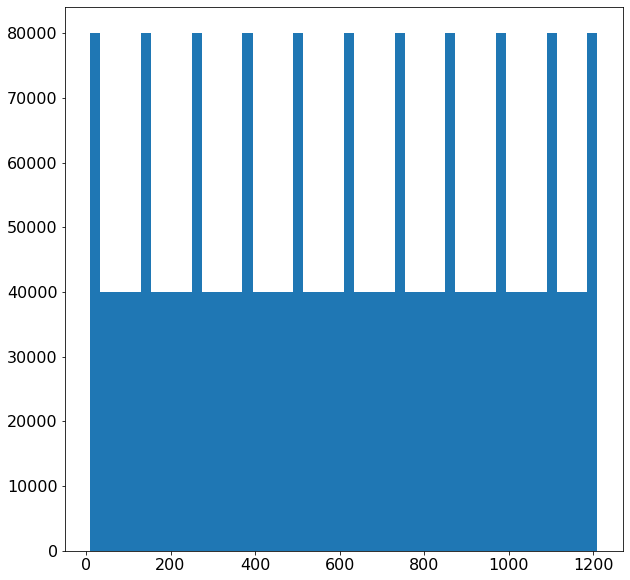

In [69]:
psf =  dstio.load_dst(out_psf, 'PSF', 'PSFs')
plt.hist(psf.z, bins=50);

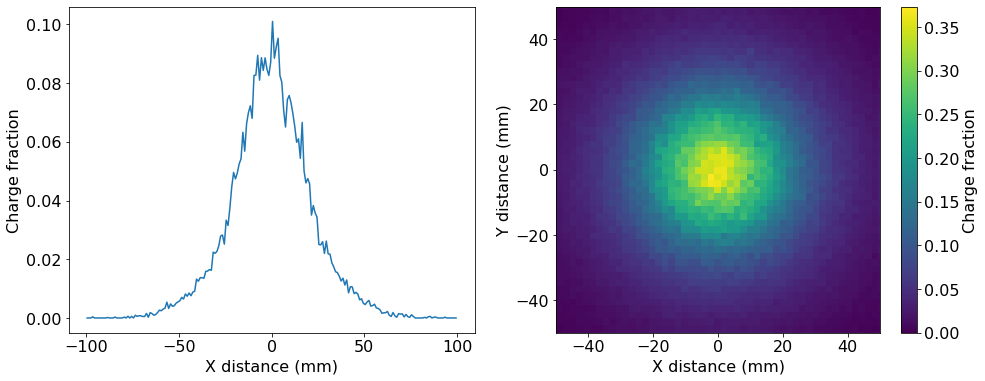

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

### Plot PSF at center (X dimension)
p1 = psf[(psf.z==610.) & (psf.yr==0.5)]
x, y = sorted(set(p1.xr)), p1.groupby(['xr'])['factor'].sum().values
axes[0].plot(x, y)
axes[0].set_xlabel('X distance (mm)')
axes[0].set_ylabel('Charge fraction')

### PSF (2D)
p1 = psf[(psf.z==610.)]
x, y, e = p1.xr.values, p1.yr.values, p1.factor.values
xb, yb  = np.linspace(Xrange[0], Xrange[1], Xrange[1]), np.linspace(Yrange[0], Yrange[1], Yrange[1])
img = axes[1].hist2d(x, y, bins=[xb,yb], weights=e)
axes[1].set_xlabel('X distance (mm)')
axes[1].set_ylabel('Y distance (mm)')
axes[1].set_xlim(-50, 50)
axes[1].set_ylim(-50, 50)
cb = fig.colorbar(img[3], ax=axes[1])

cb.set_label('Charge fraction')